# xG

xG has gained traction in the past few years in the football analytics community. It tells us about the probability of a shot being scored. It's value ranges from 0 to 1. 1 signifying a definite goal, and 0 signifying a definite miss.

Model 1 = Logistic Regression <br>
Model 2 = Random Forests <br>
Model 3 = AdaBOOST <br>

In [6]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import log_loss
from sklearn.calibration import calibration_curve

sns.set_context('poster')


In [7]:
def plot_ROC_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()
def plot_PR_curve(recall, precision):
    plt.plot(recall, precision, color='blue', label='PR')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()
def plot_pr_curve(y,ytest_prob):
    precision, recall, thresholds = metrics.precision_recall_curve(y, ytest_prob)
    plot_PR_curve(recall,precision)
    f1score = 2*precision*recall/(precision+recall)
    index = np.argmax(f1score)
    optimal_threshold= thresholds[index]
    return optimal_threshold,f1score[index],recall[index],precision[index]
def plot_roc_curve(y,ytest_prob):
    fpr, tpr, thresholds = metrics.roc_curve(y, ytest_prob)
    plot_ROC_curve(fpr,tpr)
    auc = roc_auc_score(y,ytest_prob)
    gmean = np.sqrt(tpr * (1 - fpr))
    index = np.argmax(gmean)
    optimal_threshold= thresholds[index]
    
    
def optimal_confusion_matrix(y,ytest_prob,optimal_threshold):
    ytemp=(ytest_prob > optimal_threshold).astype(int)
    mat= confusion_matrix(y,ytemp) 
    sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False)
    accuracy=accuracy_score(y,ytemp)
    print('The optimal accuracy is ' ,accuracy)


In [8]:
allshots=pd.read_csv('shots.csv')
allshots

,playerId,id,x_coordinates,y_coordinates,blocked,goal,time,matchPeriod,counter,competition,foot,bodypart,preferrence,angles,distance,headers
0,25413,177959212,92.40,27.88,0.0,1.0,2.0,0,0.0,0,1.0,1.0,1.0,26.77,14.01,0.0
1,26150,177959247,89.25,35.36,0.0,0.0,3.0,0,0.0,0,0.0,2.0,1.0,25.99,15.81,0.0
2,14763,177959280,100.80,35.36,0.0,1.0,4.0,0,0.0,0,1.0,3.0,1.0,78.79,4.41,1.0
3,7868,177959289,85.05,22.44,0.0,0.0,7.0,0,0.0,0,1.0,2.0,0.0,15.74,23.06,0.0
4,7868,177959429,78.75,20.40,0.0,0.0,14.0,0,0.0,0,1.0,1.0,1.0,12.59,29.56,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43073,25575,90588469,81.90,41.48,1.0,0.0,85.0,1,0.0,6,1.0,2.0,0.0,16.36,24.28,0.0
43074,25575,90588583,97.65,28.56,0.0,0.0,91.0,1,0.0,6,1.0,1.0,1.0,37.46,9.14,0.0
43075,70410,90589205,94.50,25.84,0.0,0.0,13.0,2,0.0,6,1.0,3.0,1.0,25.19,13.30,1.0
43076,70410,90589254,80.85,31.28,0.0,1.0,3.0,3,0.0,6,1.0,1.0,1.0,17.03,24.30,0.0


# Features 
**x_coordinates** - the closer the player is to the goal, higher is the probability of the goal being scored.  <br><br>
**y_coordinates** - the closer the player is to the centre of the goal, higher is the probaboility of the goal being scored.<br>  <br>
**angles** - greater angles imply that the player is close to the goal with a better view of of it and hence a larger area to aim at. <br><br>
**counter** - goals are easier to score in a counterattack. <br><br>
**preference** - the quality of shot is directly dependent on the preferred foot being used or not.<br><br>
**distance** - less is better. <br><br>
**headers** - Headers might positively or negatively affect the goal scoring chance.

In [9]:
model_input = allshots[['x_coordinates','y_coordinates','angles','counter','preferrence','distance','headers']]
model_output = np.ravel(allshots[['goal']])

In [10]:
from sklearn.model_selection import train_test_split
X1, X2, y1, y2 = train_test_split(model_input, model_output, random_state=0,
train_size=0.8)

## LOGISTIC REGRESSION

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
pipe_1=make_pipeline(LogisticRegression())

In [12]:
grid_values = [{'logisticregression__C': [0.001,0.01,0.1,1,3,5,7,10,100]}]

In [13]:
grid_1 = GridSearchCV(pipe_1, param_grid = grid_values,scoring = 'f1',verbose=1, cv=5)

In [14]:
grid_1.fit(X1,y1)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:    7.2s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('logisticregression',
                                        LogisticRegression())]),
             param_grid=[{'logisticregression__C': [0.001, 0.01, 0.1, 1, 3, 5,
                                                    7, 10, 100]}],
             scoring='f1', verbose=1)

In [15]:
grid_1.best_score_

0.181408159787053

In [16]:
grid_1.best_params_

{'logisticregression__C': 1}

In [17]:
ytest_labels1=grid_1.predict(X2)
ytest_prob1=grid_1.predict_proba(X2)[:,1]

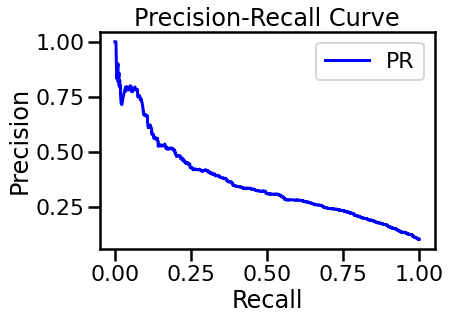

In [18]:
threshold1,f1score1,recall1,precision1=plot_pr_curve(y2,ytest_prob1)
threshold1=np.around(threshold1,4)
f1score1=np.around(f1score1,4)
recall1=np.around(recall1,4)
precision1=np.around(precision1,4)

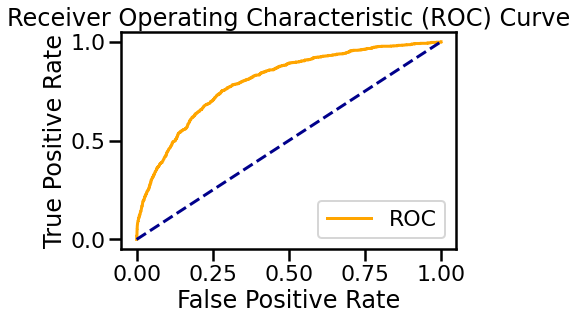

In [19]:
plot_roc_curve(y2,ytest_prob1)

In [20]:
log_loss1=log_loss(y2, ytest_prob1, eps=1e-15)
log_loss1=np.around(log_loss1,4)

Text(0.5, 1.0, 'Reliability Curve')

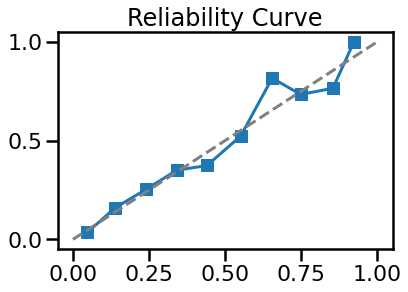

In [21]:
fraction_of_positives1, mean_predicted_values1 = calibration_curve(y2, ytest_prob1, n_bins=10)
plt.plot(mean_predicted_values1, fraction_of_positives1, 's-')
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.title('Reliability Curve')

## RANDOM FOREST

In [22]:
from sklearn.ensemble import RandomForestClassifier

In [23]:
pipe_2 = make_pipeline(RandomForestClassifier())
grid_values_2 = [{'randomforestclassifier__n_estimators': [100,200], 'randomforestclassifier__max_depth':[6,8,10]}]
grid_2 = GridSearchCV(pipe_2, param_grid = grid_values_2,scoring = 'f1',verbose=1, cv=5)

In [24]:
grid_2.fit(X1,y1)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   51.0s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('randomforestclassifier',
                                        RandomForestClassifier())]),
             param_grid=[{'randomforestclassifier__max_depth': [6, 8, 10],
                          'randomforestclassifier__n_estimators': [100, 200]}],
             scoring='f1', verbose=1)

In [25]:
grid_2.best_score_

0.18120834023466365

In [26]:
grid_2.best_params_

{'randomforestclassifier__max_depth': 8,
 'randomforestclassifier__n_estimators': 100}

In [27]:
ytest_labels2=grid_2.predict(X2)
ytest_prob2=grid_2.predict_proba(X2)[:,1]

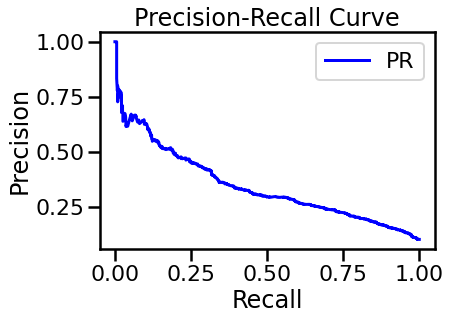

In [28]:
threshold2,f1score2,recall2,precision2=plot_pr_curve(y2,ytest_prob2)
threshold2=np.around(threshold2,4)
f1score2=np.around(f1score2,4)
recall2=np.around(recall2,4)
precision2=np.around(precision2,4)

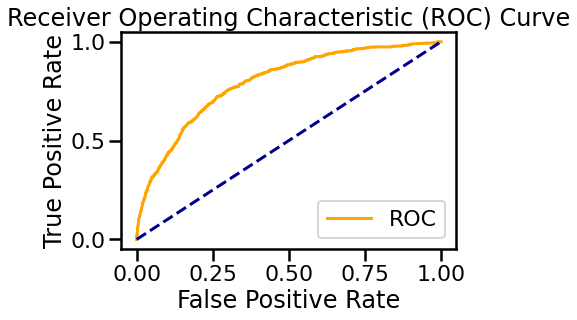

In [29]:
plot_roc_curve(y2,ytest_prob2)

In [30]:
log_loss2=log_loss(y2, ytest_prob2, eps=1e-15)
log_loss2=np.around(log_loss2,4)

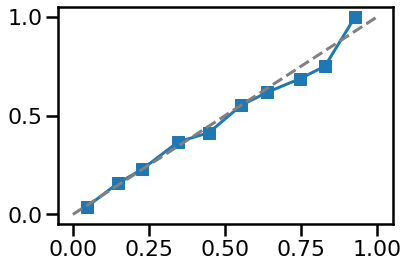

In [31]:
fraction_of_positives2, mean_predicted_values2 = calibration_curve(y2, ytest_prob2, n_bins=10)
plt.plot(mean_predicted_values2, fraction_of_positives2, 's-')
plt.plot([0, 1], [0, 1], '--', color='gray')

## AdaBOOST

In [32]:
from sklearn.ensemble import AdaBoostClassifier

In [33]:
pipe_3=make_pipeline(AdaBoostClassifier())
grid_values_3 = [{'adaboostclassifier__n_estimators': [100], 'adaboostclassifier__learning_rate':np.arange(0.1,1.1,0.1)}]

In [34]:
grid_3 = GridSearchCV(pipe_3, param_grid = grid_values_3,scoring = 'f1',verbose=1, cv=5)

In [35]:
grid_3.fit(X1,y1)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  1.1min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('adaboostclassifier',
                                        AdaBoostClassifier())]),
             param_grid=[{'adaboostclassifier__learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                          'adaboostclassifier__n_estimators': [100]}],
             scoring='f1', verbose=1)

In [36]:
grid_3.best_params_

{'adaboostclassifier__learning_rate': 0.6,
 'adaboostclassifier__n_estimators': 100}

In [37]:
grid_3.best_score_

0.19482542809832332

In [38]:
ytest_labels3=grid_3.predict(X2)
ytest_prob3=grid_3.predict_proba(X2)[:,1]

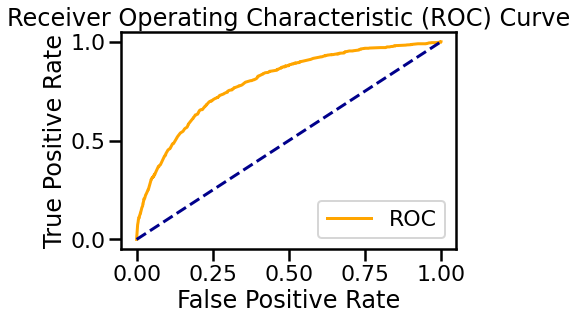

In [39]:
plot_roc_curve(y2,ytest_prob3)

In [40]:
log_loss(y2, ytest_prob3, eps=1e-15)

0.6742704791586309

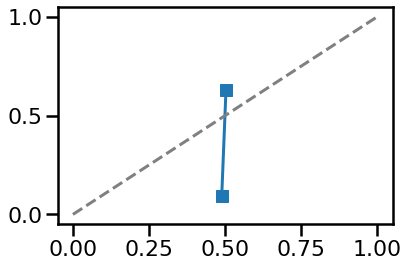

In [41]:
fraction_of_positives3, mean_predicted_values3 = calibration_curve(y2, ytest_prob3, n_bins=10)
plt.plot(mean_predicted_values3, fraction_of_positives3, 's-')
plt.plot([0, 1], [0, 1], '--', color='gray')

This shows us that AdaBOOST is not a well calibrated classifier as the probabilities cannot be interpreted as a confidence level. Hence we need to calibrate the predicted probabilities in order to get good 'xG' values

In [42]:
from sklearn.calibration import CalibratedClassifierCV

In [43]:
calibration = CalibratedClassifierCV(base_estimator = grid_3 , cv='prefit')

In [44]:
calibration.fit(X2,y2)

CalibratedClassifierCV(base_estimator=GridSearchCV(cv=5,
                                                   estimator=Pipeline(steps=[('adaboostclassifier',
                                                                              AdaBoostClassifier())]),
                                                   param_grid=[{'adaboostclassifier__learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                                                                'adaboostclassifier__n_estimators': [100]}],
                                                   scoring='f1', verbose=1),
                       cv='prefit')

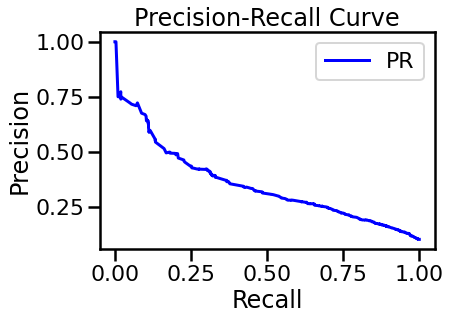

In [45]:
ytest_prob3C=calibration.predict_proba(X2)[:,1]
threshold3,f1score3,recall3,precision3=plot_pr_curve(y2,ytest_prob3C)
threshold3=np.around(threshold3,4)
f1score3=np.around(f1score3,4)
recall3=np.around(recall3,4)
precision3=np.around(precision3,4)


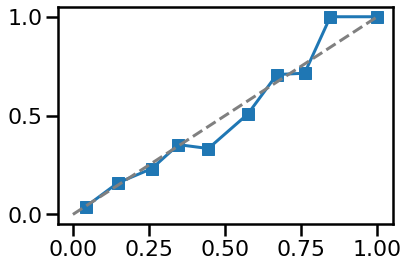

In [46]:
fraction_of_positives3C, mean_predicted_values3C = calibration_curve(y2, ytest_prob3C, n_bins=10)
plt.plot(mean_predicted_values3C, fraction_of_positives3C, 's-')
plt.plot([0, 1], [0, 1], '--', color='gray')

Post calibration the predicted probabilities become reliable

In [47]:
log_loss3=log_loss(y2, ytest_prob3C, eps=1e-15)
log_loss3=np.around(log_loss3,4)

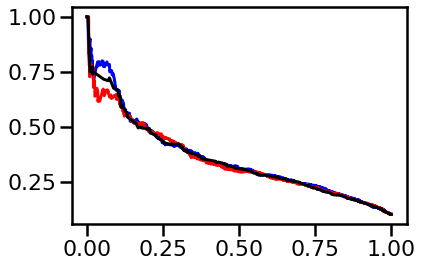

In [48]:
precisions1, recalls1, thresholds1 = metrics.precision_recall_curve(y2, ytest_prob1)
precisions2, recalls2, thresholds2 = metrics.precision_recall_curve(y2, ytest_prob2)
precisions3, recalls3, thresholds3 = metrics.precision_recall_curve(y2, ytest_prob3)
plt.plot(recalls1, precisions1, color='blue')
plt.plot(recalls2, precisions2, color='red')
plt.plot(recalls3, precisions3, color='black')



All three classifiers perform relatively same with logistic regression having a slight edge.

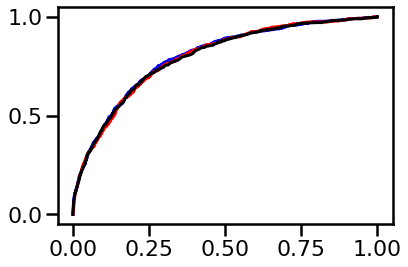

In [49]:
fprs1, tprs1, thresholds1 = metrics.roc_curve(y2, ytest_prob1)
fprs2, tprs2, thresholds2 = metrics.roc_curve(y2, ytest_prob2)
fprs3, tprs3, thresholds3 = metrics.roc_curve(y2, ytest_prob3)
plt.plot(fprs1, tprs1, color='blue')
plt.plot(fprs2, tprs2, color='red')
plt.plot(fprs3, tprs3, color='black')


In [50]:
from tabulate import tabulate

In [51]:
table = [['Model','Threshold','F1score','Precision','Recall','Log_loss'],['Logistic Regression',threshold1,f1score1,precision1,recall1,log_loss1],['Random Forest',threshold2,f1score2,precision2,recall2,log_loss2],['AdaBOOST',threshold3,f1score3,precision3,recall3,log_loss3]]

In [52]:
table

[['Model', 'Threshold', 'F1score', 'Precision', 'Recall', 'Log_loss'],
 ['Logistic Regression', 0.1591, 0.3904, 0.306, 0.5392, 0.2739],
 ['Random Forest', 0.164, 0.3861, 0.2943, 0.5609, 0.2732],
 ['AdaBOOST', 0.1624, 0.3847, 0.3049, 0.521, 0.2741]]

In [53]:
print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

╒═════════════════════╤═════════════╤═══════════╤═════════════╤══════════╤════════════╕
│ Model               │   Threshold │   F1score │   Precision │   Recall │   Log_loss │
╞═════════════════════╪═════════════╪═══════════╪═════════════╪══════════╪════════════╡
│ Logistic Regression │      0.1591 │    0.3904 │      0.306  │   0.5392 │     0.2739 │
├─────────────────────┼─────────────┼───────────┼─────────────┼──────────┼────────────┤
│ Random Forest       │      0.164  │    0.3861 │      0.2943 │   0.5609 │     0.2732 │
├─────────────────────┼─────────────┼───────────┼─────────────┼──────────┼────────────┤
│ AdaBOOST            │      0.1624 │    0.3847 │      0.3049 │   0.521  │     0.2741 │
╘═════════════════════╧═════════════╧═══════════╧═════════════╧══════════╧════════════╛


Confusion matrix for Random Forest

The optimal accuracy is  0.8182451253481894


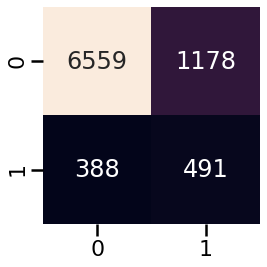

In [54]:
optimal_confusion_matrix(y2,ytest_prob2,0.164)

Confusion matrix for logistic regression

The optimal accuracy is  0.8288068709377902


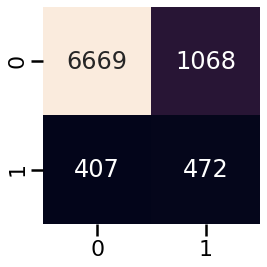

In [55]:
optimal_confusion_matrix(y2,ytest_prob1,0.1591)

All the three classifiers have relatively the same performance. I have chose Random Forest for predicting xG values on the account of it having better recall, log_loss and reliability curve. 

In [59]:
xG=grid_2.predict_proba(model_input)[:,1]

In [60]:
xG=np.around(xG,4)

In [61]:
allshots['xG']=xG

In [62]:
allshots.to_csv('allshots.csv',index=False)

In [63]:
allshots

,playerId,id,x_coordinates,y_coordinates,blocked,goal,time,matchPeriod,counter,competition,foot,bodypart,preferrence,angles,distance,headers,xG
0,25413,177959212,92.40,27.88,0.0,1.0,2.0,0,0.0,0,1.0,1.0,1.0,26.77,14.01,0.0,0.1466
1,26150,177959247,89.25,35.36,0.0,0.0,3.0,0,0.0,0,0.0,2.0,1.0,25.99,15.81,0.0,0.1106
2,14763,177959280,100.80,35.36,0.0,1.0,4.0,0,0.0,0,1.0,3.0,1.0,78.79,4.41,1.0,0.4348
3,7868,177959289,85.05,22.44,0.0,0.0,7.0,0,0.0,0,1.0,2.0,0.0,15.74,23.06,0.0,0.0331
4,7868,177959429,78.75,20.40,0.0,0.0,14.0,0,0.0,0,1.0,1.0,1.0,12.59,29.56,0.0,0.0165
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43073,25575,90588469,81.90,41.48,1.0,0.0,85.0,1,0.0,6,1.0,2.0,0.0,16.36,24.28,0.0,0.0231
43074,25575,90588583,97.65,28.56,0.0,0.0,91.0,1,0.0,6,1.0,1.0,1.0,37.46,9.14,0.0,0.2714
43075,70410,90589205,94.50,25.84,0.0,0.0,13.0,2,0.0,6,1.0,3.0,1.0,25.19,13.30,1.0,0.0895
43076,70410,90589254,80.85,31.28,0.0,1.0,3.0,3,0.0,6,1.0,1.0,1.0,17.03,24.30,0.0,0.0461


## FEATURE IMPORTANCE

In [65]:
randomforest=RandomForestClassifier(max_depth=8, n_estimators=100)

In [66]:
randomforest.fit(X1,y1)

RandomForestClassifier(max_depth=8)

In [69]:
coefficients=randomforest.feature_importances_
coefficients=np.reshape(coefficients,(7,))

In [70]:
features=['X-Coordinates','Y-Coordinates','Angles','Counter','Preference','Distance','Headers']

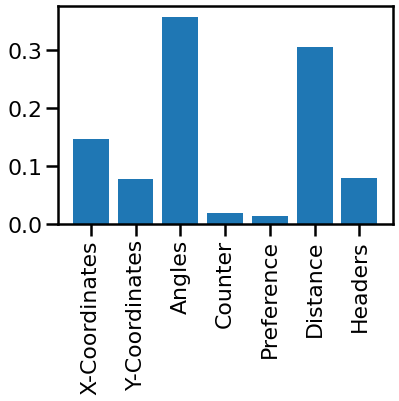

In [71]:
plt.bar(features, coefficients)
plt.xticks(rotation=90)
plt.savefig('featureimportance.png')